# Mid-Level API

As a graph visualization package built on top of NetworkX,
`nxviz`'s design is highly inspired by the grammar of graphics.
In particular, we see network visualizations
as being composed of two main components,
which correspond to the two objects that comprise a graph:

1. Nodes: their layout (position, grouping & ordering), and visual styling (color, size, and transparency).
2. Edges: their visual styling (color, width, and transparency).

In addition to these,
we may choose to add annotations and highlights
onto the network visualization,
such as node and/or edge labels,
particular nodes and/or edges being highlighted,
color bars or legends, and more.

As such, the low-level functional API is designed around these ideas.
In this notebook, we would like to highlight
how the low-level API can be used
to compose beautiful network visualizations,
as long as one structures one's thinking around these principles.

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## An example graph

To illustrate, we will use the Karate Club Graph from NetworkX's library.

In [2]:
from random import choice

import networkx as nx

In [3]:
import io
import urllib.request as urllib
import zipfile

import matplotlib.pyplot as plt
import networkx as nx

url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("football.txt").decode()  # read info file
gml = zf.read("football.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
G = nx.parse_gml(gml)  # parse gml data
print(txt)

mapping = dict(
    {
        0: "Atlantic Coast",
        1: "Big East",
        2: "Big Ten",
        3: "Big Twelve",
        4: "Conference USA",
        5: "Independents",
        6: "Mid-American",
        7: "Mountain West",
        8: "Pacific Ten",
        9: "Southeastern",
        10: "Sun Belt",
        11: "Western Athletic",
    }
)
for node, data in G.nodes(data=True):
    G.nodes[node]["conference"] = mapping[data["value"]]

The file football.gml contains the network of American football games
between Division IA colleges during regular season Fall 2000, as compiled
by M. Girvan and M. Newman.  The nodes have values that indicate to which
conferences they belong.  The values are as follows:

  0 = Atlantic Coast
  1 = Big East
  2 = Big Ten
  3 = Big Twelve
  4 = Conference USA
  5 = Independents
  6 = Mid-American
  7 = Mountain West
  8 = Pacific Ten
  9 = Southeastern
 10 = Sun Belt
 11 = Western Athletic

If you make use of these data, please cite M. Girvan and M. E. J. Newman,
Community structure in social and biological networks,
Proc. Natl. Acad. Sci. USA 99, 7821-7826 (2002).

Correction: Two edges were erroneously duplicated in this data set, and
have been removed (21 SEP 2014)



### Visualization using NetworkX's built-in facilities

NetworkX does come with its own built-in visualization facilities.
Let's see what visualizations we get.

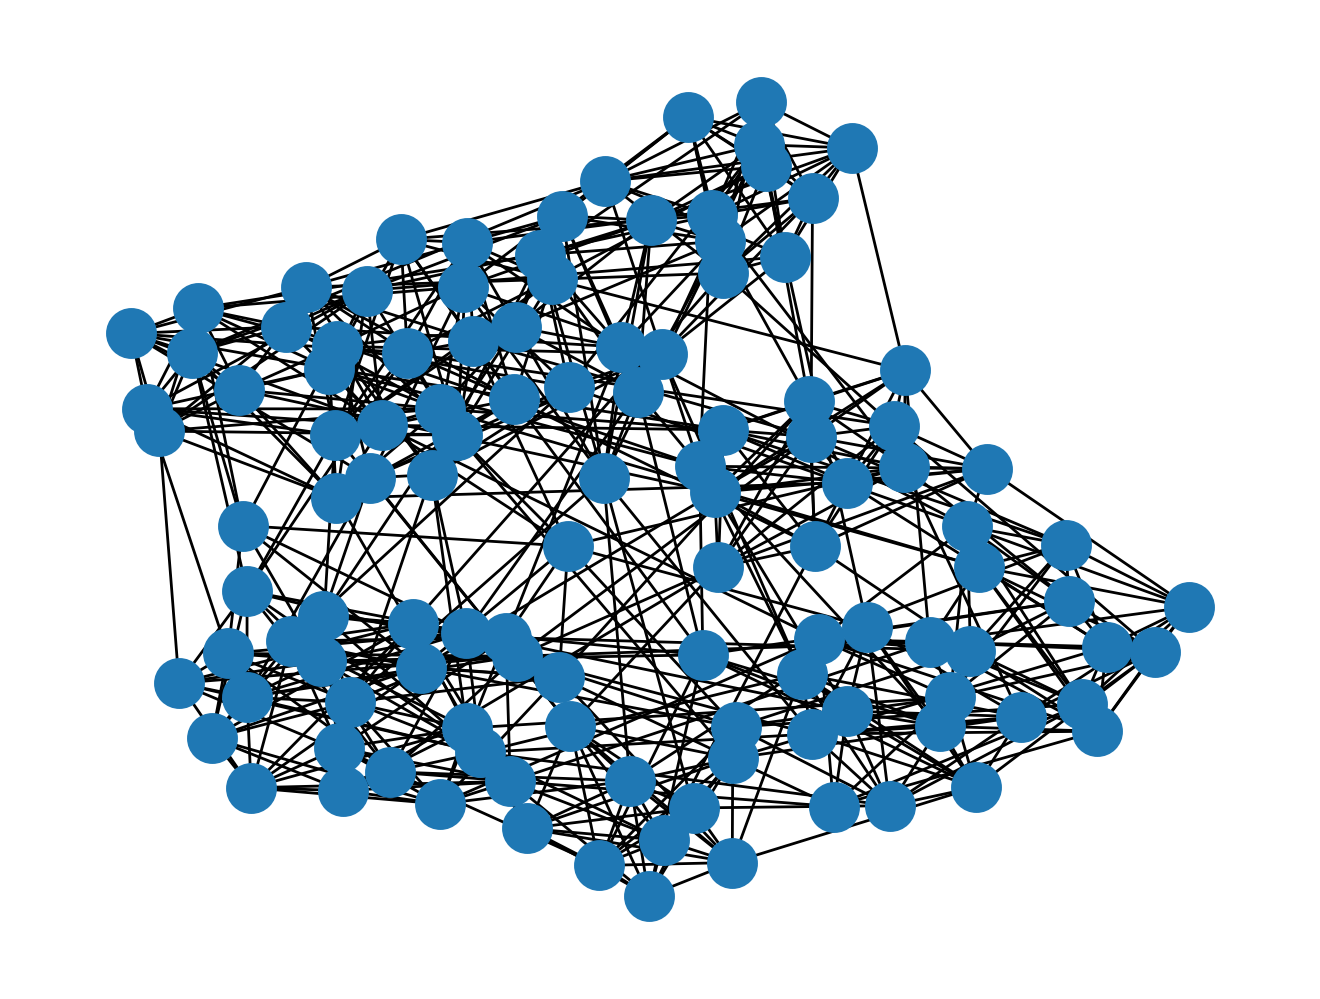

In [4]:
nx.draw(G)

That looks a bit like a hairball. How can we make it look nicer?

## Node Layout

The first thing we should worry about is the node layout.
This specifically refers to how nodes are positioned on the 2D plane.
In a rational graph visualization,
node placement should always take priority,
as nodes represent entities with properties that we can grasp.

The Circos plot layout lays out the nodes around the circumference of a circle.
Hence, by stating up-front that we want a Circos layout,
we take care of the first step of graph visualization,
that is node placement.

The `nodes` module provides a bunch of node drawing algorithms.
They all take in the graph object `G` and return a position dictionary.
That position dictionary is necessary for drawing edges, as we'll see in a moment.

/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


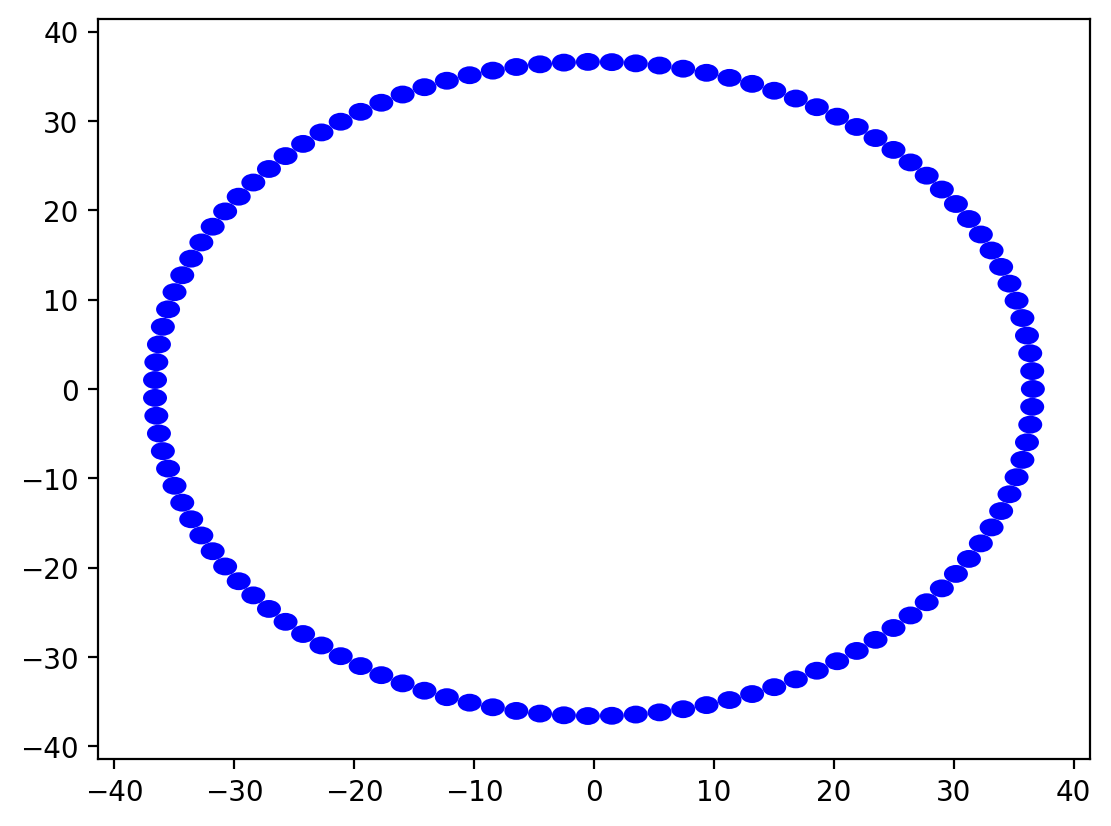

In [5]:
from nxviz import nodes

pos = nodes.circos(G)

Right now, it doesn't look like much - a blue donut, basically.
That is because there are a bunch of circles of radius 1 (the default radius)
that are overlapping with one another.
To make things a bit more informative,
we should probably group the nodes by their conference.

Here is where nxviz's API becomes apparent.
We can _refine_ the positioning of the nodes
by specifying how to group them and sort them.
This is accomplished by specifying
the `group_by` and `sort_by` keyword arguments.
Let's see the effect of specifying `group_by`:

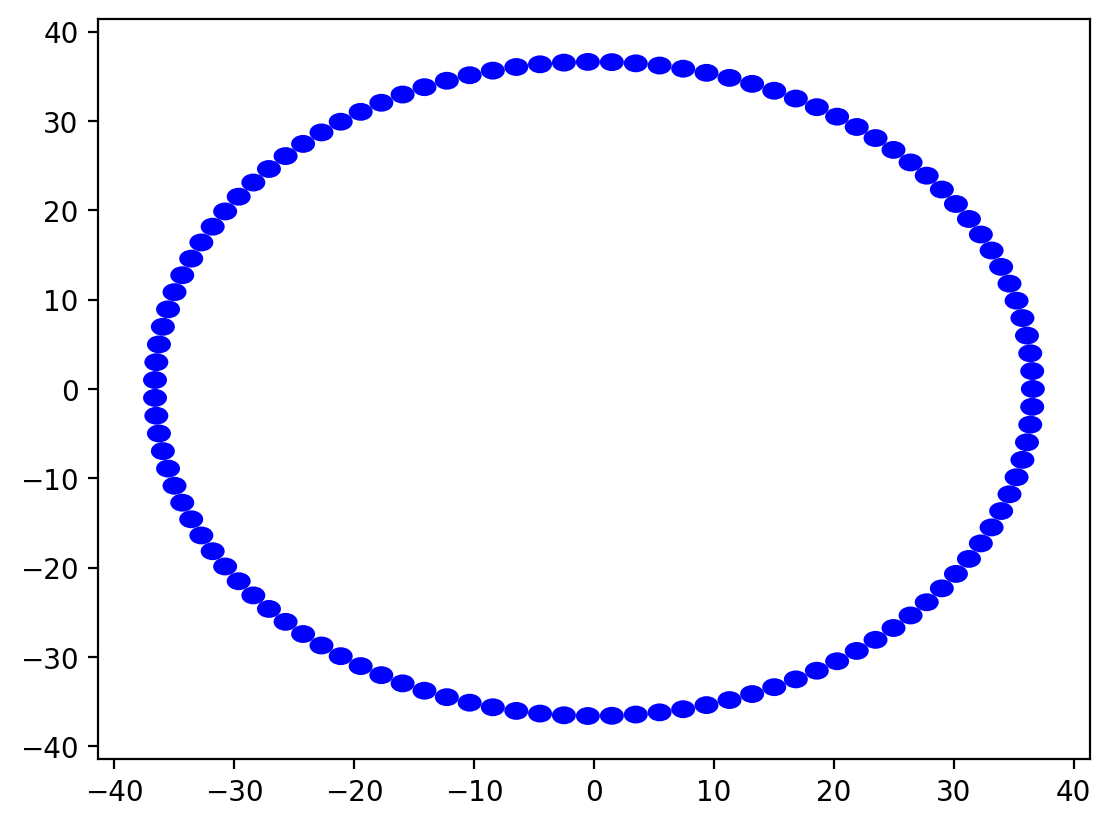

In [6]:
pos = nodes.circos(G, group_by="conference")

You might be wondering, why didn't that do anything?
Actually, it did, but things are not yet visually apparent
because we have only concerned ourselves with the _positions_ of the nodes
and not the _visual properties_ of the nodes.
The _visual properties_ of the node that can be mapped to data are
the color, the transparency, and the node size.
By default, node colors are blue,
transparency (the alpha parameter in matplotlib) is 1,
and node size is 1.
Let's see how we can declare that we want our nodes to be coloured by conference
while also being ordered by conference.

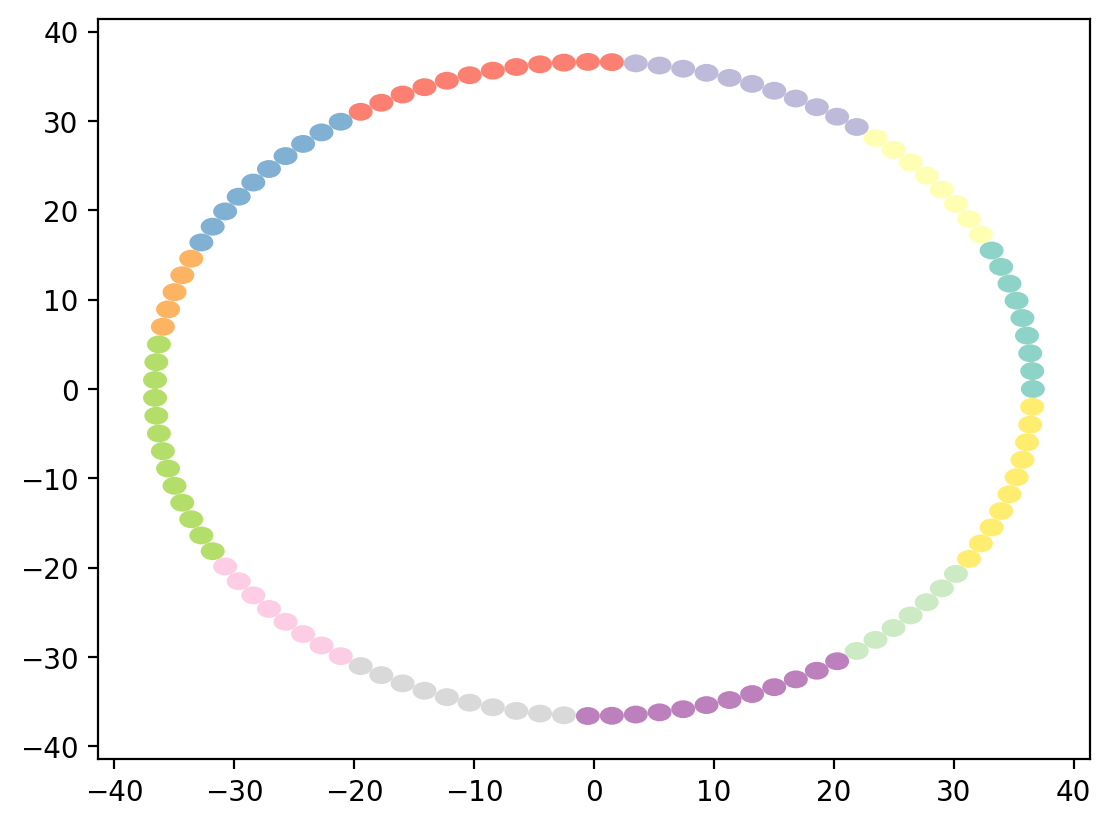

In [7]:
pos = nodes.circos(G, group_by="conference", color_by="conference")

Things are starting to look promising!
Though, if I were to comment on it, the plot is also still quite ugly.
Let's start by applying a uniform scaling factor to all of the nodes
to scale them to the size of the plot.
(This is the `size_scale` encoding keyword argument that we'll be specifying below.)

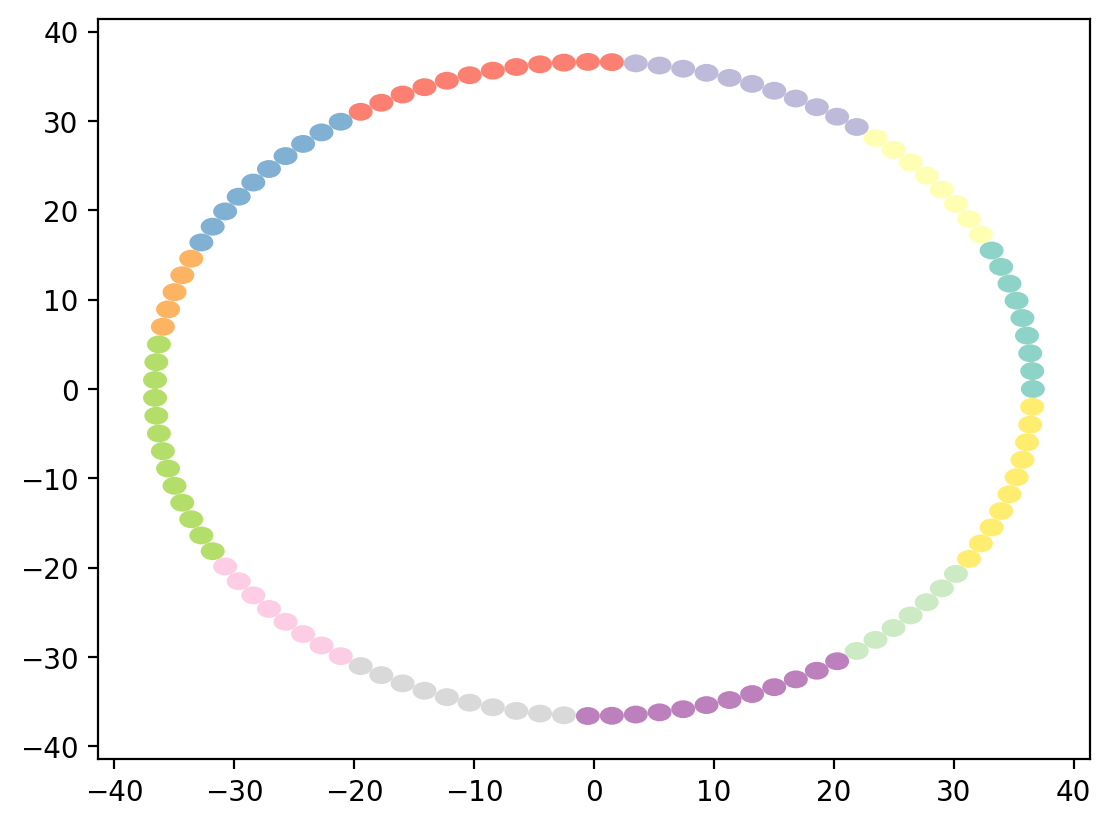

In [8]:
pos = nodes.circos(G, group_by="conference", color_by="conference")

The nodes look a bit more appropriately sized!
The Circos plot still looks a bit squishy though.
There's some _adjustments_ we need to do to the plot to make it look nice.
We need to remove the spines and ticks to get rid of the boxiness effect.
We also need to make the aspect ratio on the x- and y-axes equal.

`despine()` will accomplish the first.

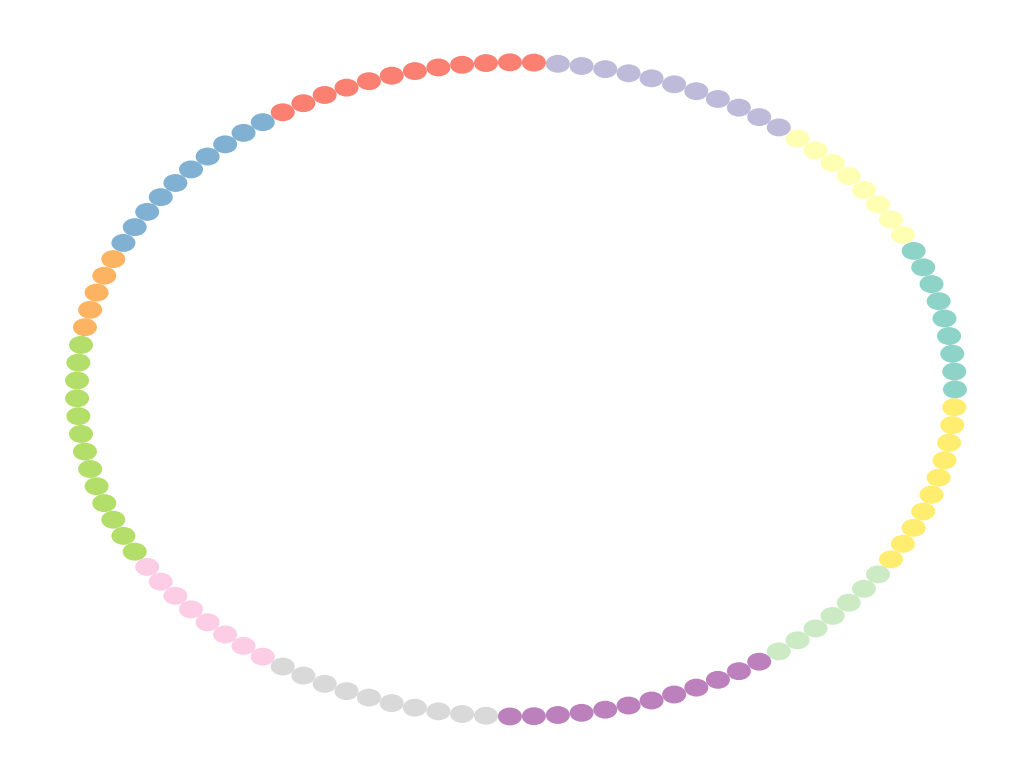

In [9]:
from nxviz.plots import aspect_equal, despine

pos = nodes.circos(G, group_by="conference", color_by="conference")
despine()

Putting it together with `aspect_equal()` will get us to a good starting point.

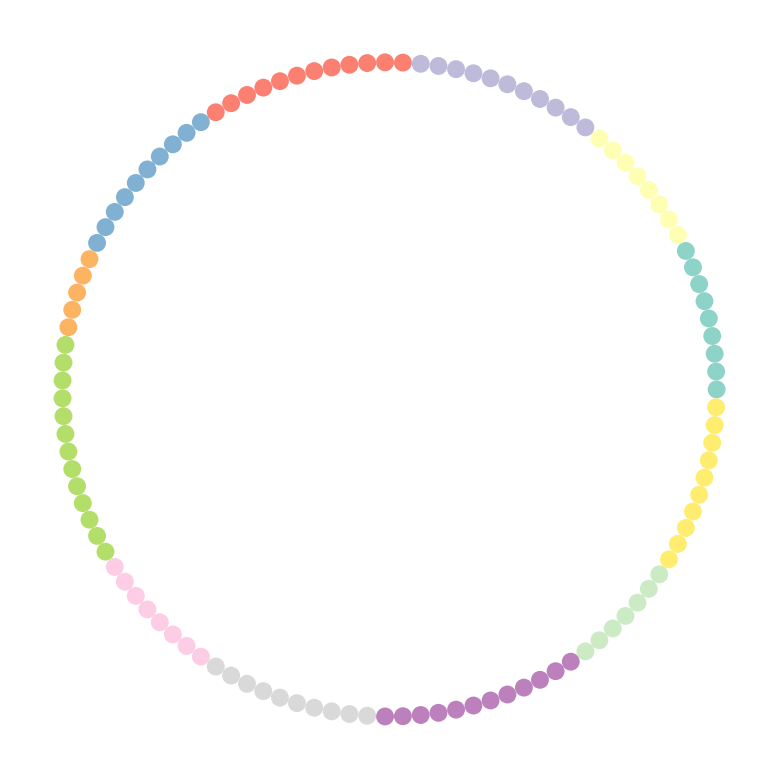

In [10]:
pos = nodes.circos(G, group_by="conference", color_by="conference")
despine()
aspect_equal()

_Voila!_
With the nodes rationally laid out,
we have an awesome starting point for adding in the edges.

Edge drawing requires that we have the positions of the nodes available.
That we obtain from the `nodes.circos` (or other node drawing) function.
We can then pass it to any of the edge drawing functions.

When drawing edges, because we are drawing relations and not entities,
we are no longer concerned with grouping and sorting.
Instead, we are concerned with only the visual properties of the lines.
The ones that are most easily mappable to data are:

1. Line width
2. Transparency
3. Line color

The `edges.circos` function is the most logical here, so we'll kick off with that one.

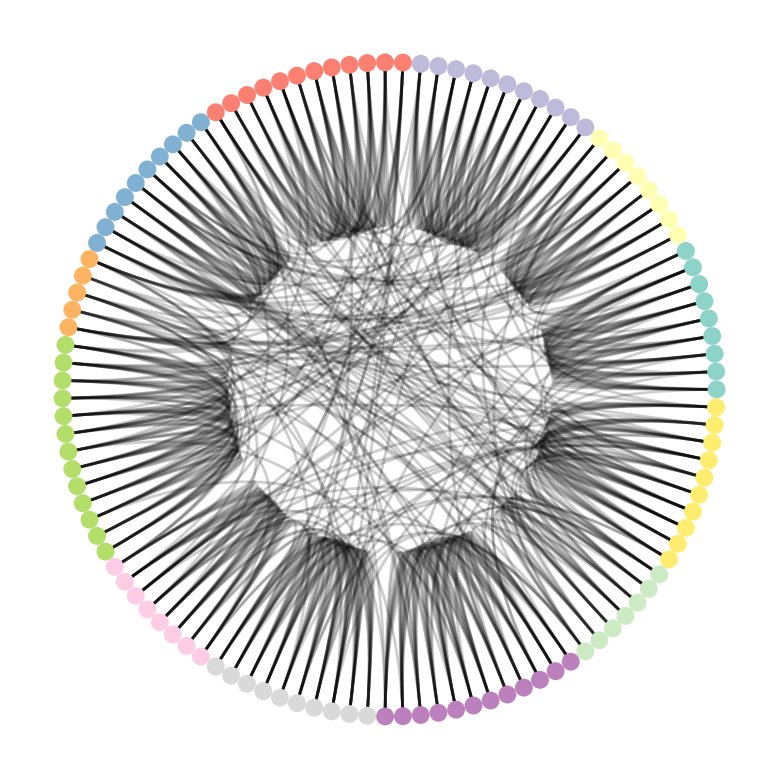

In [11]:
from nxviz import edges

pos = nodes.circos(G, group_by="conference", color_by="conference")
edges.circos(G, pos)

despine()
aspect_equal()

An alternative to drawing circos edges is to draw lines directly for each edge.

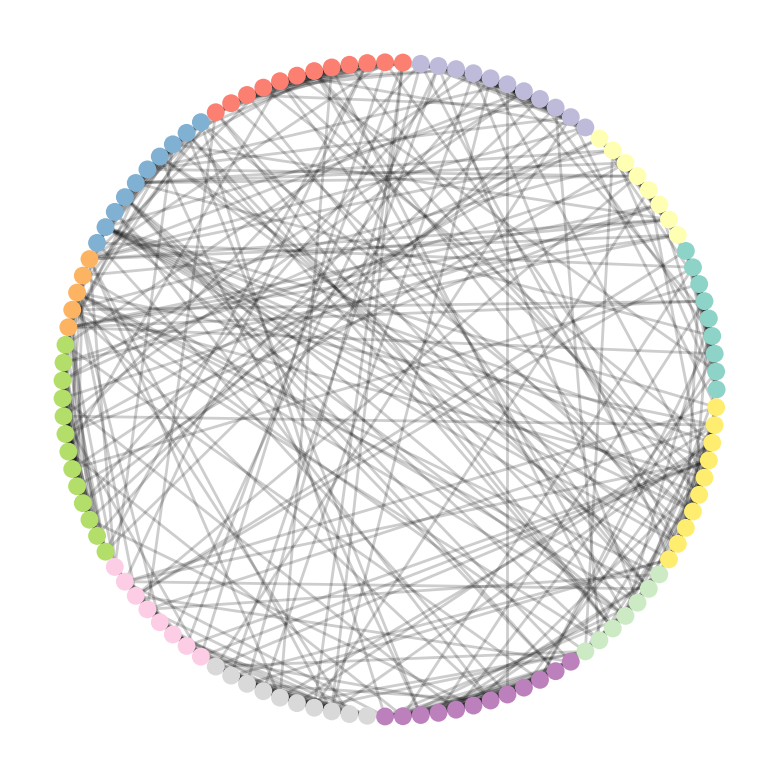

In [12]:
pos = nodes.circos(G, group_by="conference", color_by="conference")
edges.line(G, pos)

despine()
aspect_equal()

Regardless of which edge drawing method we choose,
the chart might not be sufficiently ready for our purposes, though.
After all, we have no idea what groups map to which color.
If we _annotate_ the _circos group_ onto the plot,
it becomes much clearer which colors map to which group.

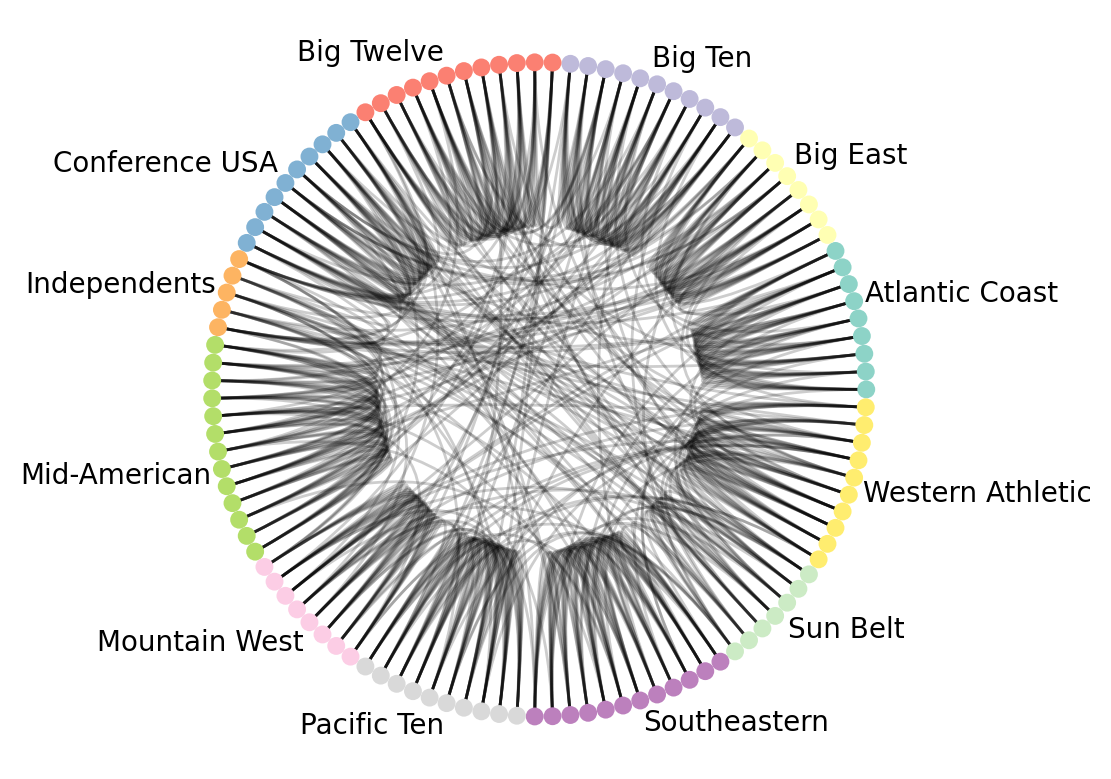

In [13]:
from nxviz import annotate

pos = nodes.circos(G, group_by="conference", color_by="conference")
edges.circos(G, pos)
annotate.circos_group(G, group_by="conference")

despine()
aspect_equal()

Now it is clear that there are quite a lot of within-conference edges,
and only some cross-conference edges between teams.

## Other layouts

### Arc layout

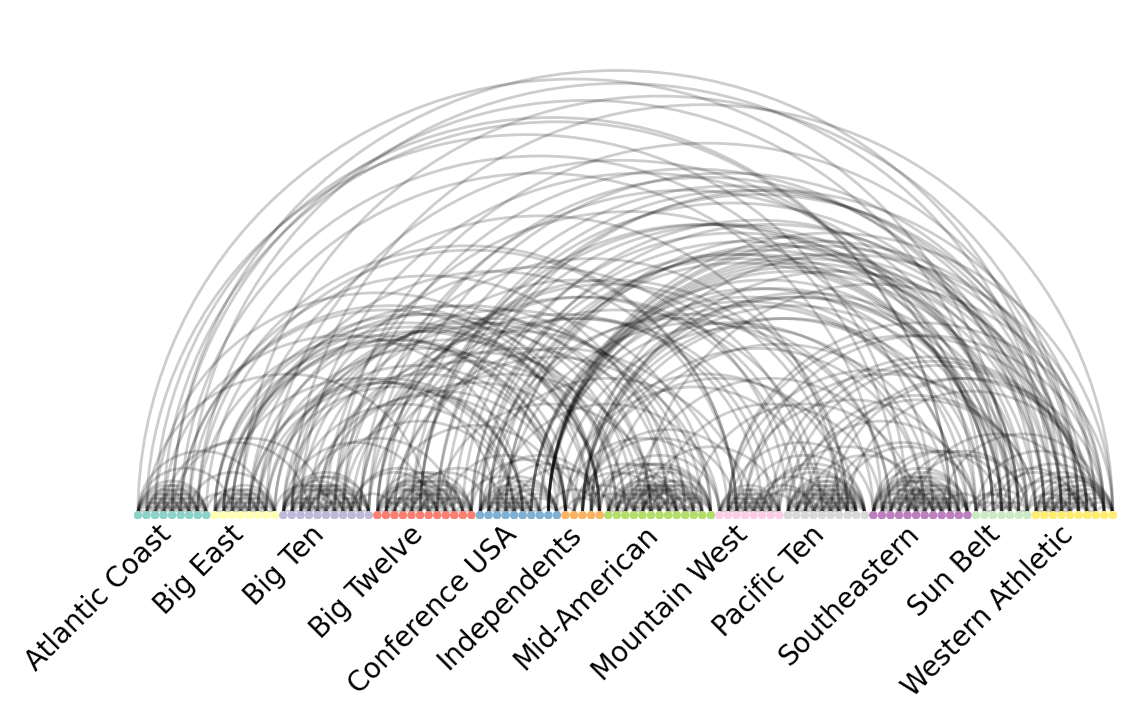

In [14]:
pos = nodes.arc(G, group_by="conference", color_by="conference")
edges.arc(G, pos)
annotate.arc_group(G, group_by="conference")

despine()
aspect_equal()

### Parallel coordinates layout

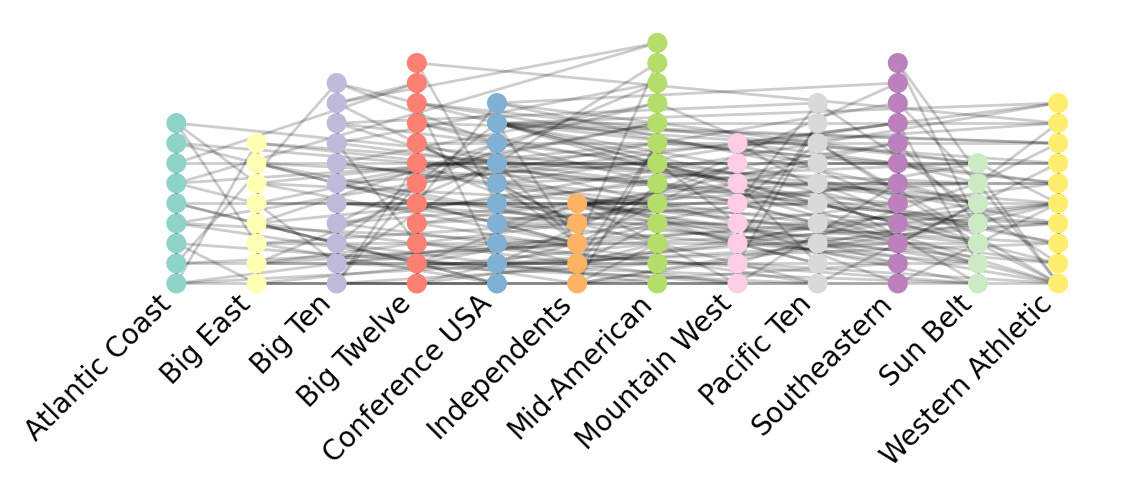

In [15]:
from nxviz import edges, nodes

pos = nodes.parallel(G, group_by="conference", color_by="conference")
edges.line(G, pos)
annotate.parallel_group(G, group_by="conference")
despine()
aspect_equal()

The parallel coordinates layout might not necessarily be the most informative for this graph dataset,
but we still show it here just to give you a flavour for what is possible with it.
It may be more suited to bipartite graphs,
which explicitly do not allow for edges within a single group.

## Hive plot layout

The hive plot is a bit special, in that it is suitable for only plotting a maximum of 3 groups.
If we isolate nodes from just the Atlantic Coast, Independents, and Sun Belt,
then we have a suitable way of plotting hive plots.

Grouping is crucial to the Hive plot; we........

Notice here that we take advantage of the `node_table` version of a graph's nodes,
which is essentially a listing of all of the nodes and their properties.
The node table works well for unipartite graphs,
but needs to be modified for bipartite graphs.

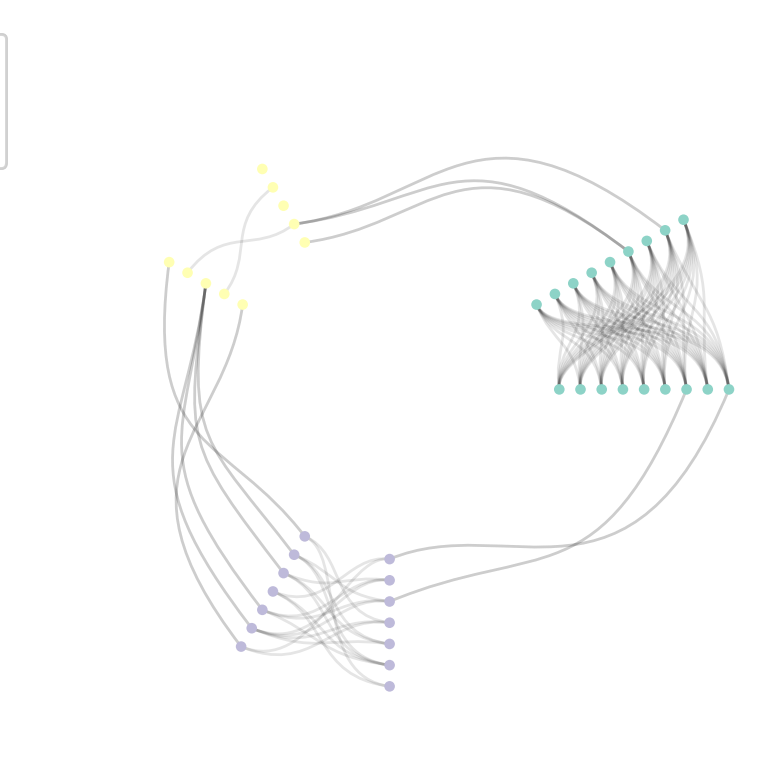

In [16]:
import numpy as np

from nxviz import nodes
from nxviz.utils import node_table

conferences = ["Atlantic Coast", "Independents", "Sun Belt"]
nt = node_table(G)
wanted_nodes = nt.query("`conference` in @conferences").index

G_sub = G.subgraph(wanted_nodes)

size_scale = 0.5
# radius = 2
pos = nodes.hive(G_sub, group_by="conference", color_by="conference")
pos_cloned = nodes.hive(
    G_sub,
    group_by="conference",
    color_by="conference",
    layout_kwargs=dict(rotation=np.pi / 6),
)
edges.hive(G_sub, pos, pos_cloned=pos_cloned)
annotate.node_colormapping(G_sub, color_by="conference")
despine()
aspect_equal()

And here, we see an interesting pattern show up that might not have been visible earlier on:
The Atlantic Coast teams have a lot of in-group edges than between-group edges,
while the independents appear to have lots more between-group edges than in-group edges.

## Conclusions

This notebook's intent is to show you how the mid-level API of `nxviz`
expresses a thought framework for drawing networks in a rational fashion.
We start with a particular layout (positions) for the nodes,
deciding on their grouping and ordering.
We then declare their size, color, and transparency,
based on data attributes that are present on there.

Next, we declare the way to draw edges.
Each layout has its own particular idiomatic edge drawing method,
and usually the easiest way to handle this is to use the corresponding edges function.

APIs that live at a higher level of abstraction usually imply more restrictions,
as the intent here is usually to trade off customizable details for simplicity.
The mid-level API allows us to gain finer-grained control over plots while remaining declarative.
Changing the colormap, in particular, is out of scope for the mid-level API.

The highest level of the `nxviz` API is object-based
and opinionatedly pairs certain node layouts with certain edge drawing functions,
not allowing for any customization there.
The lowest-level API is where one interacts with the lines, layouts, positions directly,
exposing more direct interaction with `matplotlib`.